Train a simple topic modeling model to uncover the topics present in a collection of Git repositories, allowing developers to gain insights into the primary themes and subjects within the codebase.

In [ ]:
import sys
print("Python version")
print(sys.version)

Python version
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#current directory check
%pwd

'/content'

In [ ]:
%env

{'SHELL': '/bin/bash',
 'NV_LIBCUBLAS_VERSION': '11.11.3.6-1',
 'NVIDIA_VISIBLE_DEVICES': 'all',
 'COLAB_JUPYTER_TRANSPORT': 'ipc',
 'NV_NVML_DEV_VERSION': '11.8.86-1',
 'NV_CUDNN_PACKAGE_NAME': 'libcudnn8',
 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events',
 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.15.5-1+cuda11.8',
 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.15.5-1',
 'VM_GCE_METADATA_HOST': '169.254.169.253',
 'HOSTNAME': 'a0a5ed48f6f9',
 'LANGUAGE': 'en_US',
 'TBE_RUNTIME_ADDR': '172.28.0.1:8011',
 'GCE_METADATA_TIMEOUT': '3',
 'NVIDIA_REQUIRE_CUDA': 'cuda>=11.8 brand=tesla,driver>=450,driver<451 brand=tesla,driver>=470,driver<471 brand=unknown,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=nvidiartx,driver>=470,driver<471 brand=geforce,driver>=470,driver<471 brand=geforcertx,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=titan,driver>=470,driver<471 brand=tit

In [ ]:
# folder path: "/content/drive/MyDrive/ml-549-course-main/homeworks/fall23_hw1/readmes"

In [ ]:
pip install --upgrade pip


In [ ]:
#requirements

%pip install nltk
%pip install scikit-learn
%pip install matplotlib
%pip install gensim
%pip install seaborn
%pip install wordcloud
%pip install pyLDAvis


In [ ]:
!pip install --upgrade numpy

In [ ]:
!pip3 install nltk
!pip3 install _ilp64

ERROR: Invalid requirement: '_ilp64'


In [ ]:
#imports

import numpy
import os
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.matutils import Sparse2Corpus
import pandas as pd
import seaborn as sns


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

AttributeError: ignored

## Reading the files

In [ ]:
# Reading the file content of readmes

folder_path = "/content/drive/MyDrive/ml-549-course-main/homeworks/fall23_hw1/datasets/readmes"

readme_files = []
for filename in os.listdir(folder_path):
    if filename.endswith(".md"):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8', errors='ignore') as file:
            readme_files.append(file.read())


## Exploratory data analysis

In [ ]:
# Check for Empty Files
empty_files = [filename for filename, content in zip(os.listdir(folder_path), readme_files) if not content.strip()]
print(f"Number of empty files: {len(empty_files)}")
print(f"Empty files: {empty_files}")

# Check for Files with Low Word Count
low_word_count_files = [filename for filename, content in zip(os.listdir(folder_path), readme_files) if len(content.split()) < 10]  # Assuming less than 10 words is low.
print(f"Number of files with low word count: {len(low_word_count_files)}")
print(f"Files with low word count: {low_word_count_files}")

#  Length Distribution
file_lengths = [len(content.split()) for content in readme_files]
plt.hist(file_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of File Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Files')
plt.show()


# Non-English Content
%pip install langdetect
from langdetect import detect

non_english_files = [filename for filename, content in zip(os.listdir(folder_path), readme_files) if detect(content) != 'en']
print(f"Number of non-English files: {len(non_english_files)}")
print(f"Non-English files: {non_english_files}")


Number of empty files: 0
Empty files: []
Number of files with low word count: 1
Files with low word count: ['devstream_README.md']


NameError: ignored

## Q2.2 Pre-Processing

In [ ]:
# Preprocess readmes

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Convert text to lowercase
    text = text.lower()

    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'```.*?```', '', text, flags=re.DOTALL)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenizing and removing punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]  # Keep only alphanumeric tokens

    # Removing stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Removing the word related to "kubernetes"
    tokens = [word for word in tokens if word not in ['kubernetes', 'cluster', 'use', 'file','see', 'using']]


    # Lemmatizing
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return " ".join(tokens)

processed_texts = [preprocess(text) for text in readme_files]


In [ ]:
print(len(processed_texts))

184


In [ ]:
processed_lengths = [len(text.split()) for text in processed_texts]

# Files that became empty after preprocessing
empty_processed_files = [filename for filename, content in zip(os.listdir(folder_path), processed_texts) if not content.strip()]
print(f"Number of files that became empty after preprocessing: {len(empty_processed_files)}")
print(f"Files: {empty_processed_files}")

# Files with very few words after preprocessing
low_word_processed_files = [filename for filename, content in zip(os.listdir(folder_path), processed_texts) if len(content.split()) < 5]  # Assuming less than 5 words is low after preprocessing.
print(f"Number of processed files with low word count: {len(low_word_processed_files)}")
print(f"Processed files with low word count: {low_word_processed_files}")


Number of files that became empty after preprocessing: 0
Files: []
Number of processed files with low word count: 1
Processed files with low word count: ['devstream_README.md']


In [ ]:
# Excluding 'devstream_README.md' from the processed_texts and readme_files
excluded_files = ['devstream_README.md']
processed_texts = [text for text, filename in zip(processed_texts, os.listdir(folder_path)) if filename not in excluded_files]
readme_files = [content for content, filename in zip(readme_files, os.listdir(folder_path)) if filename not in excluded_files]


In [ ]:
# TF-IDF implementation
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words=stopwords.words('english'))
tfidf_matrix = vectorizer.fit_transform(processed_texts)
tfidf_dense_matrix = tfidf_matrix.toarray()

In [ ]:
print(tfidf_dense_matrix)

[[0.         0.         0.08748489 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.04846301 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.06026225 0.         0.        ]]


## Q2.3 Training and Evaluation

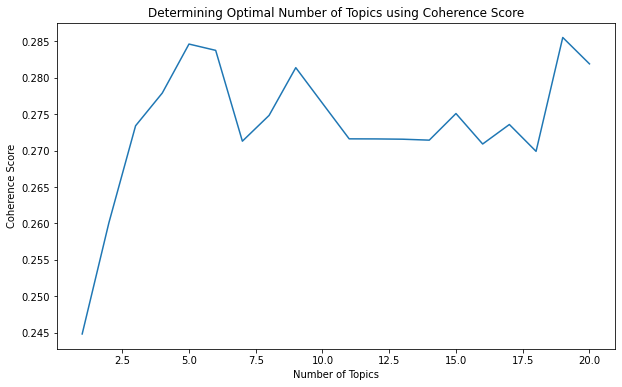

optimal_num_topics:  19
Topics without labels:
Topic: 0
Words: project container metric docker run application community version build please release api image license code service support status configuration example set value environment source cloud get resource need cncf running go default issue storage development policy documentation github system feature install test used like check command user flag make started
--------------------------------------------------
Topic: 1
Words: project resource image application cloud support run command api license karmada version release check get community policy service container node build environment storage set status code please spiffe v running cluster need used meeting also following user join default slack documentation docker native source open example go create deployment chart
--------------------------------------------------
Topic: 2
Words: metric support component project please also version network service configuration releas

In [ ]:
# gensim's LDA
dictionary = corpora.Dictionary([text.split() for text in processed_texts])
corpus = [dictionary.doc2bow(text.split()) for text in processed_texts]

max_topics = 20
coherence_scores = []

for num_topics in range(1, max_topics+1):
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence = CoherenceModel(model=lda, texts=[text.split() for text in processed_texts], dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)

# Plotting coherence scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_topics+1), coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Determining Optimal Number of Topics using Coherence Score')
plt.show()

# highest coherence score
optimal_num_topics = coherence_scores.index(max(coherence_scores)) + 1
print("optimal_num_topics: ", optimal_num_topics)

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, random_state=42)

print("Topics without labels:")
for idx, topic in lda_model.print_topics(-1, num_words=50):
    words_only = " ".join(re.findall(r'"(.*?)"', topic))
    print(f"Topic: {idx}\nWords: {words_only}\n{'-'*50}")


print("\n\nTopics with labels:")
topic_labels = {}
for idx, topic in lda_model.print_topics(-1, num_words=50):
    words_only = " ".join(re.findall(r'"(.*?)"', topic))
    label = words_only.split()[0]
    topic_labels[idx] = label
    print(f"Topic: {idx}\nLabel: {label}\nWords: {words_only}\n{'-'*50}")


In [ ]:
# Function to get the dominant topic for each document in the corpus
def get_dominant_topic(lda_model, corpus, texts):

    doc_topics_df = pd.DataFrame()

    for i, row_list in enumerate(lda_model[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['Dominant_Topic', 'Percentage_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return doc_topics_df

df_topic_assignments = get_dominant_topic(lda_model=lda_model, corpus=corpus, texts=processed_texts)

print(df_topic_assignments.head())


   Dominant_Topic  Percentage_Contribution  \
0            16.0                   0.6811   
1             8.0                   0.5345   
2             3.0                   0.7036   
3            11.0                   0.7056   
4             9.0                   0.6787   

                                      Topic_Keywords  \
0  release, image, run, container, build, metric,...   
1  project, please, release, image, support, reso...   
2  project, image, container, community, security...   
3  configuration, container, service, check, proj...   
4  metric, support, project, release, prometheus,...   

                                                   0  
0  table content hexa policy orchestratorhexapoli...  
1  artifact hub ci go report card cii best practi...  
2  envoy logo cloudnative highperformance edgemid...  
3  telepresence fast efficient local development ...  
4  prometheus jvm client support java clojure sca...  


## Plots with autogenerated labels

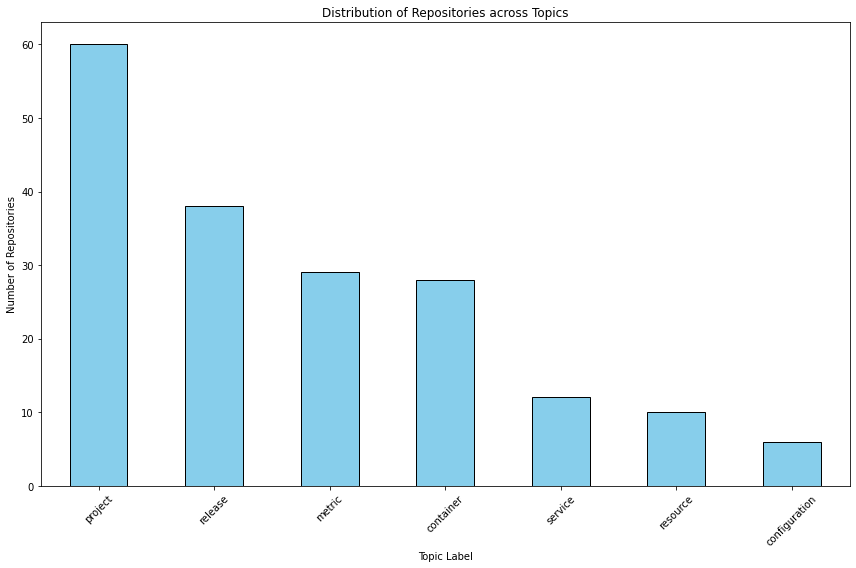

In [ ]:
# Bar plot
topic_label_counts = df_topic_assignments['Dominant_Topic'].apply(lambda x: topic_labels[x]).value_counts()

plt.figure(figsize=(12, 8))
topic_label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Repositories across Topics')
plt.xlabel('Topic Label')
plt.ylabel('Number of Repositories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

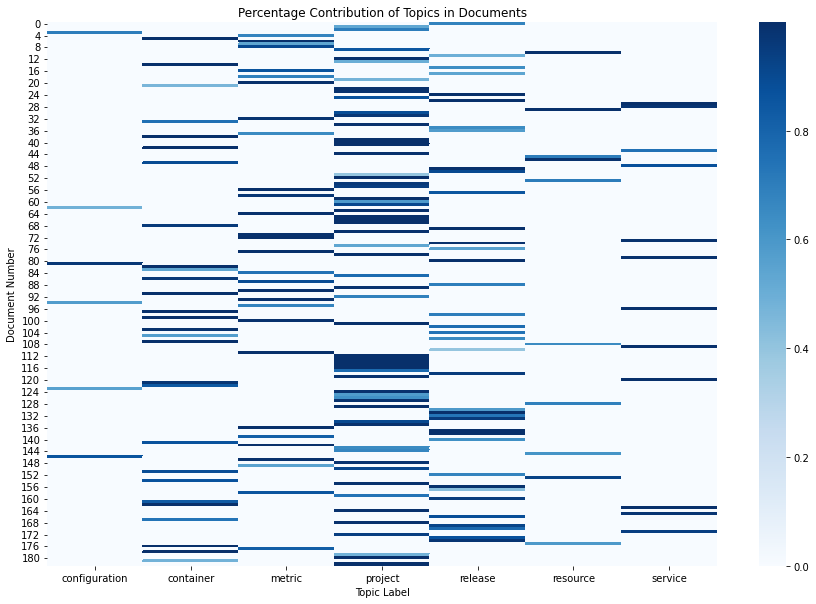

In [ ]:
# Heatmap plot

df_topic_assignments['Topic_Label'] = df_topic_assignments['Dominant_Topic'].map(topic_labels)

topic_matrix = df_topic_assignments.pivot_table(index=df_topic_assignments.index, columns='Topic_Label', values='Percentage_Contribution', fill_value=0)

plt.figure(figsize=(15, 10))
sns.heatmap(topic_matrix, cmap='Blues')
plt.title('Percentage Contribution of Topics in Documents')
plt.xlabel('Topic Label')
plt.ylabel('Document Number')
plt.show()


In [ ]:
# Interactive plot

import pyLDAvis
import pyLDAvis.gensim as gensimvis

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)


## Plots with human generated labels

In [ ]:
'''

Topic: 0
Words: project container metric docker run application community version build please release api image license code service support status configuration example set value environment source cloud get resource need cncf running go default issue storage development policy documentation github system feature install test used like check command user flag make started
--------------------------------------------------
Topic: 1
Words: project resource image application cloud support run command api license karmada version release check get community policy service container node build environment storage set status code please spiffe v running cluster need used meeting also following user join default slack documentation docker native source open example go create deployment chart
--------------------------------------------------
Topic: 2
Words: metric support component project please also version network service configuration release cloud community storage user run repository container detail cni value api feature get license default pod following plugins expose code server used resource make example need linux build application opentelemetry environment available meeting x label client collector flag note
--------------------------------------------------
Topic: 3
Words: project image container community security code cloud run support application component please provider build meeting version environment resource key license feature configuration default policy get release detail cncf source example repository service data command system chaos documentation also docker issue user used karmada api make need set flag running create
--------------------------------------------------
Topic: 4
Words: container support image application linux run default code version project community value command go example please documentation also cloud issue expose service yes list user used docker node system configuration x start cncf security api make need environment license detail note install data way want running build component resource release
--------------------------------------------------
Topic: 5
Words: service community helm project container command metric image application user release code support mesh need cncf run get meeting version default chart slack resource cloud build api native docker install please flag list open github developer documentation status control go check also following prometheus time set used value repository issue
--------------------------------------------------
Topic: 6
Words: resource volume container application release run build image node community v command api project cloud go version documentation metric please feature license also code server storage get data change service user default detail check open value meeting docker new support pod configuration status provider install used need note native help
--------------------------------------------------
Topic: 7
Words: release application version service metric issue project code community resource get go node chaos v image build please request need example client run license cloud new support set yes data feature documentation status api user policy server cncf change mesh following join like used list also security install default meeting
--------------------------------------------------
Topic: 8
Words: project please release image support resource documentation code security run status cncf build check community cloud container contributing issue license meeting version information also detail go repository default component feature source used need policy example get application user development time operator metric available way running make report work docker open
--------------------------------------------------
Topic: 9
Words: metric support project release prometheus version build data example go service application default community docker container storage used license configuration run image environment documentation v code also system user following component get need please cloud provides cncf time cortex status command meeting available check slack value detail server source client
--------------------------------------------------
Topic: 10
Words: metric project run release support version build go service please container system community security cloud issue get policy application docker feature image default example open x list repository configuration need help code meeting status node source slack new prometheus license check report resource note want used user detail running also
--------------------------------------------------
Topic: 11
Words: configuration container service check project storage run default get community chaos resource status image need build version environment application support pod command please also cd api metric meeting code license kuberhealthy prometheus user openebs deployment data example contributing start available docker telepresence slack cncf installation set release component option server
--------------------------------------------------
Topic: 12
Words: container support image project service build version license default run go feature user docker please command release metric get also x example mesh network slim configuration new issue data value antrea open protocol install flag application channel native api used environment runtime jaeger security running policy cncf make add name
--------------------------------------------------
Topic: 13
Words: release example project application build run service metric prometheus support version container feature get configuration user repository license go set default please image name meeting detail command following helm environment check documentation available chart install storage new change page tool path directory code need value also package cncf community source
--------------------------------------------------
Topic: 14
Words: container pod release gadget project example run version image expose cloud inspektor security system user etcd runtime linux build api policy metric also flag service server command go value access license please running install default application new code environment used configuration status node need get resource documentation branch client statistic
--------------------------------------------------
Topic: 15
Words: project community application falco service cloud container code support feature network policy please release slack deployment repository metric issue cncf status spire spiffe run get security license environment resource cni native documentation version go example also build open user list api system workload used need configuration request docker provides meeting
--------------------------------------------------
Topic: 16
Words: release image run container build metric cloud support version configuration community go docker project service example environment user resource default application command policy status please chaos data get used license running source code value expose issue system test documentation prometheus also need meeting time mesh slack install meshery feature cncf
--------------------------------------------------
Topic: 17
Words: container image command project support default community example please security api version repository build feature used target user release docker environment run value also flag system key detail yes data slim need component name issue help note license runtime path running github documentation change storage set code directory cloud following
--------------------------------------------------
Topic: 18
Words: container default metric image run flag collect build command version docker cloud name slim service value server set application configuration node system example please get target runtime expose status following submariner project network http linux used environment chaos path note option need detail directory support user license running edge time
--------------------------------------------------

'''
topic_labels = {
    0: "Project Container Overview",
    1: "Cloud Resource Management",
    2: "Network Component Metrics",
    3: "Cloud Security & Infrastructure",
    4: "Linux-based Containerization",
    5: "Service Mesh & Helm Deployment",
    6: "Volume & Node Configuration",
    7: "Application Release Management",
    8: "Project Documentation & Security",
    9: "Monitoring & Data Metrics",
    10: "Storage & Chaos Configuration",
    11: "Networking & Feature Development",
    12: "Metric-driven Deployments",
    13: "Runtime Security & Pod Management",
    14: "Network Policy & Service Deployment",
    15: "Cloud Image Configurations",
    16: "Container Commands & Security",
    17: "Metric Collection & Networking"
}


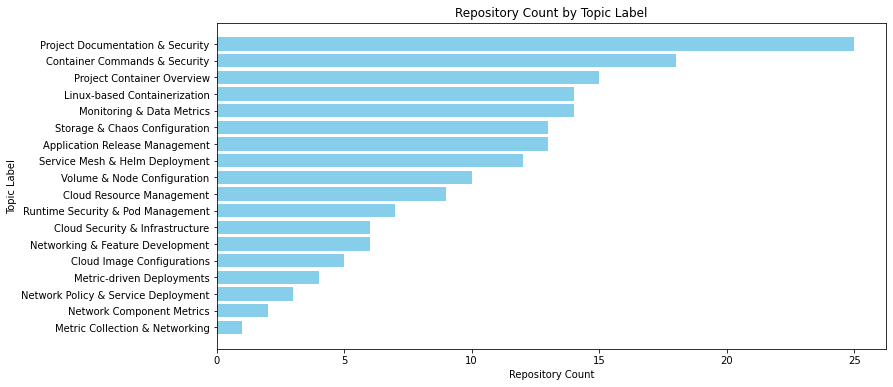

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_topic_assignments['Topic_Label'] = df_topic_assignments['Dominant_Topic'].map(topic_labels)

topic_counts = df_topic_assignments['Topic_Label'].value_counts().reset_index()
topic_counts.columns = ['Topic_Label', 'Repository_Count']

topic_counts = topic_counts.sort_values(by='Repository_Count', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(topic_counts['Topic_Label'], topic_counts['Repository_Count'], color='skyblue')
plt.xlabel('Repository Count')
plt.ylabel('Topic Label')
plt.title('Repository Count by Topic Label')
plt.gca().invert_yaxis()
plt.show()


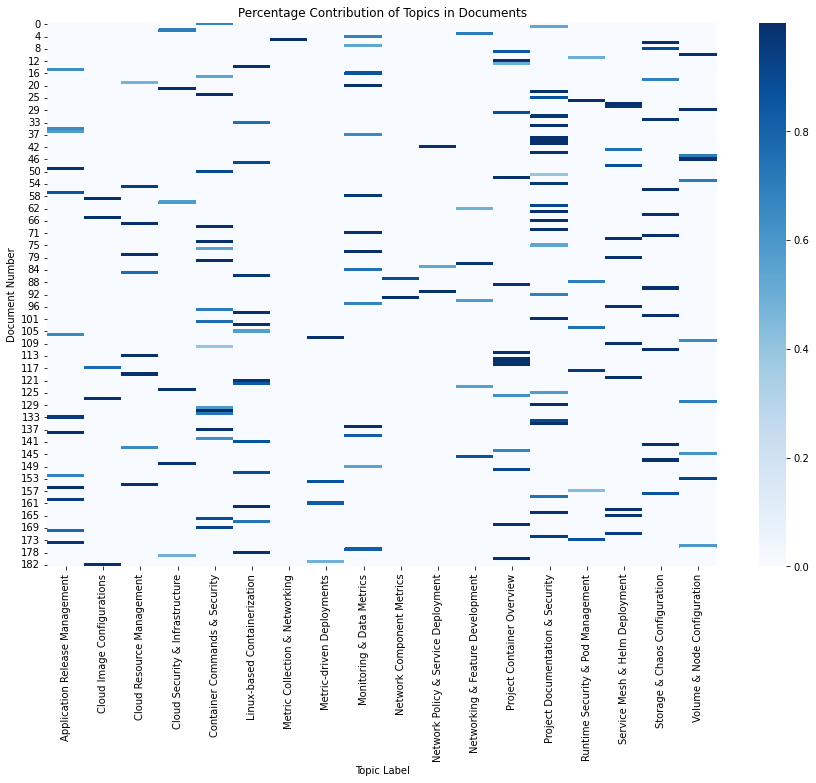

In [ ]:
import seaborn as sns

df_topic_assignments['Topic_Label'] = df_topic_assignments['Dominant_Topic'].map(topic_labels)

topic_matrix = df_topic_assignments.pivot_table(index=df_topic_assignments.index, columns='Topic_Label', values='Percentage_Contribution', fill_value=0)

plt.figure(figsize=(15, 10))
sns.heatmap(topic_matrix, cmap='Blues')
plt.title('Percentage Contribution of Topics in Documents')
plt.xlabel('Topic Label')
plt.ylabel('Document Number')
plt.show()


In [ ]:
pyLDA_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(pyLDA_data)